# Figure 1E

Layered spiking network model covering 4x4 mm^2 at biologically realistic neuron density. Activity is evoked at t=700 ms by a spatially and temporally confined thalamic pulse. Evoked activity propagates through the network as displayed in the spike raster plot and sequence of snapshots of spatiotemporally binned firing rates.

Authors: Johanna Senk, Espen Hagen

In [1]:
import os
import sys
import numpy as np
import scipy.sparse as sp
import pickle
import h5py
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import mpl_toolkits.mplot3d.art3d as art3d

fs = 8
matplotlib.rcParams.update({
    'figure.dpi': 600,
    'font.size': fs, 'axes.labelsize': fs, 'xtick.labelsize': fs, 'xtick.labelsize': fs,
    'axes.xmargin': 0., 'axes.ymargin': 0., 'axes.labelpad': 0.1, 'lines.linewidth': 1.})

This figure panel is concerned with a layered spiking network model covering 4x4 mm$^2$ at biologically realistic neuron density. The model is organized into four cortical layers (L2/3, L4, L5, and L6), each one of which contains an excitatory (E) and inhibitory (I) neuron population. An additional population of thalamocortical neurons (TC) can provide external input. First, we draw a network sketch:

In [2]:
# define labels and colors
layer_labels = np.array(['L2/3', 'L4', 'L5', 'L6'])
pop_labels = np.array(['L2/3E', 'L2/3I', # TODO not used here
                       'L4E', 'L4I',
                       'L5E', 'L5I',
                       'L6E', 'L6I',
                       'TC'])
pop_labels = np.array(['L2/3E', 'L2/3I',
                       'L4E', 'L4I',
                       'L5E', 'L5I',
                       'L6E', 'L6I',
                       'TC'])
pop_colors = np.array(['#114477',   # L23E blue
                       '#77AADD',   # L23I
                       '#117744',   # L4E green
                       '#88CCAA',   # L4I
                       '#774411',   # L5E brown
                       '#DDAA77',   # L5I
                       '#771155',   # L6E pompadour
                       '#CC99BB',   # L6I
                       '#696969'])  # TC  dimgrey

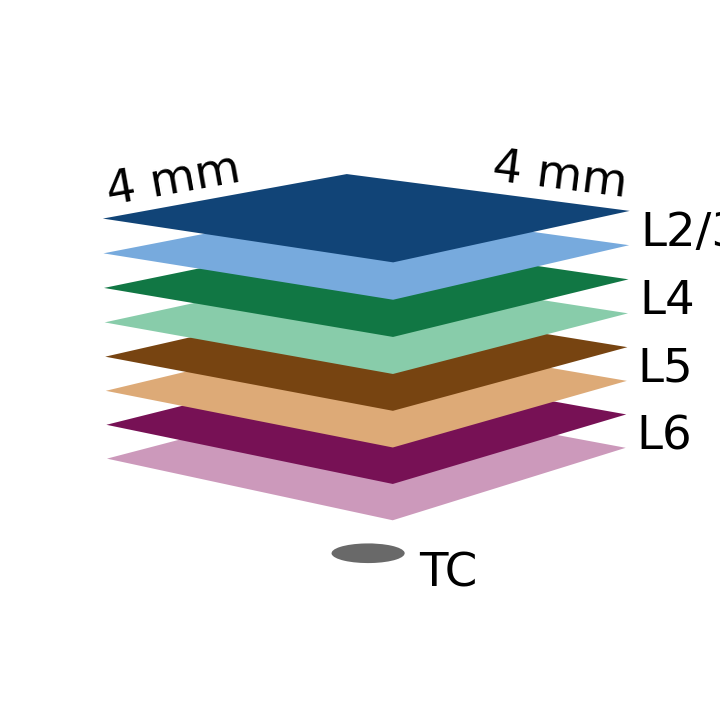

In [3]:
def plot_mesocircuit_icon(gs, elev=12, azim=-50, scale_fs=0.7, pop_color=pop_colors, layer_labels=layer_labels):
        """
        Plots a schematic network icon to gridspec cell.

        Parameters
        ----------
        gs
            A gridspec cell to plot into.
        elev
            Elevation angle in z-plane.
        azim
            Azimuth angle in x,y-plane.
        scale_fs
            Scaling factor for font size.
        """
        ax = plt.subplot(gs, projection='3d')

        for i, col in enumerate(pop_colors[::-1]):
            if i == 0:  # TC
                patch = Circle((0.5, 0.5), 0.1, facecolor=col)
                z = -2 / (len(pop_colors) - 1)
                xshift = 0.4
                yshift = 0.4
                label = pop_labels[-1]
            else:
                patch = Rectangle((0, 0), 1, 1, facecolor=col)
                z = i / (len(pop_colors) - 1)
                xshift = -0.02
                yshift = -0.02
                label = layer_labels[::-1][int((i - 1) / 2)]
            ax.add_patch(patch)
            art3d.pathpatch_2d_to_3d(patch, z=z, zdir="z")
            if not i % 2:
                ax.text(1. - xshift, 1 - yshift, z, label,
                        fontsize=matplotlib.rcParams['font.size'] * scale_fs,
                        verticalalignment='top')

        ax.text(1, 1, 1.05, '4 mm', 'x',
                fontsize=matplotlib.rcParams['font.size'] * scale_fs,
                horizontalalignment='right')
        ax.text(0, 0, 1.05, '4 mm', 'y',
                fontsize=matplotlib.rcParams['font.size'] * scale_fs,
                horizontalalignment='left')

        ax.grid(False)
        ax.view_init(elev=elev, azim=azim)
        plt.axis('off')
        return

fig_width = 1#8.5/2.54 # TODO
fig = plt.figure(figsize=(fig_width, fig_width))
gs = gridspec.GridSpec(1,1)
gs.update(left=0, right=2, bottom=0, top=1)
plot_mesocircuit_icon(gs[0])

Next, we want to inspect simulated data obtained in a NEST simulation of the model. The raw simulation output consists of the spike times and corresponding neuron IDs as well as the position in 2D space of each neuron. For convenience, we load here three preprocessed datasets from file:
1. `all_sptrains`: The spike trains of all neurons.
2. `all_pos_sorting_arrays`: Array with indices for sorting neuron IDs according to a sorting axis (here: x-axis).
3. `all_inst_rates_bintime_binspace`: Time- and space-binned instantaneous firing rates averaged over neurons in spatial bins. 

In [4]:
data_dir = 'live_paper_figure'
key = 'favorite_evoked'
hash = 'ba7f30c811b1a99a40a513841dd8db87'

model_path = os.path.join(data_dir, key, hash)

d = {}
for all_datatype in ['all_sptrains',
                     'all_pos_sorting_arrays',
                     'all_inst_rates_bintime_binspace']:
    fn = os.path.join(
        model_path,
        'processed_data',
        all_datatype + '.h5')
    data = h5py.File(fn, 'r')
    d.update({all_datatype: data})


def load_h5_to_sparse_X(X, h5data, sparsetype='csr'):
    """
    Loads sparse matrix stored in COOrdinate format in HDF5.

    Parameters
    ----------
    X:
        Group name for datasets
        'data', 'row', 'col' vectors of equal length
        'shape' : shape of array tuple
    h5data:
        Open .h5 file.
    sparsetype: str
        scipy.sparse matrix type in 
        ['csr', 'array', 'bsr', 'coo', 'csc', 'csr', 
         'dense', 'dia', 'dok', 'lil']. 
        Default is 'csr'
    
    Returns
    -------
    scipy.sparse matrix
    """
    assert sparsetype in ['csr', 'array', 'bsr', 'coo', 'csc', 'csr', 'dense', 
                    'dia', 'dok', 'lil'], f'type {sparsetype} not supported'
    data_X = sp.coo_matrix((h5data[X]['data_row_col'][()][:, 0],
                            (h5data[X]['data_row_col'][()][:, 1],
                             h5data[X]['data_row_col'][()][:, 2])),
                           shape=h5data[X]['shape'][()])
    if sparsetype == 'coo':
        return data_X
    else:
        return getattr(data_X, f'to{sparsetype}')()

Create a spike raster plot.

Text(0.5, 1.0, 'TC')

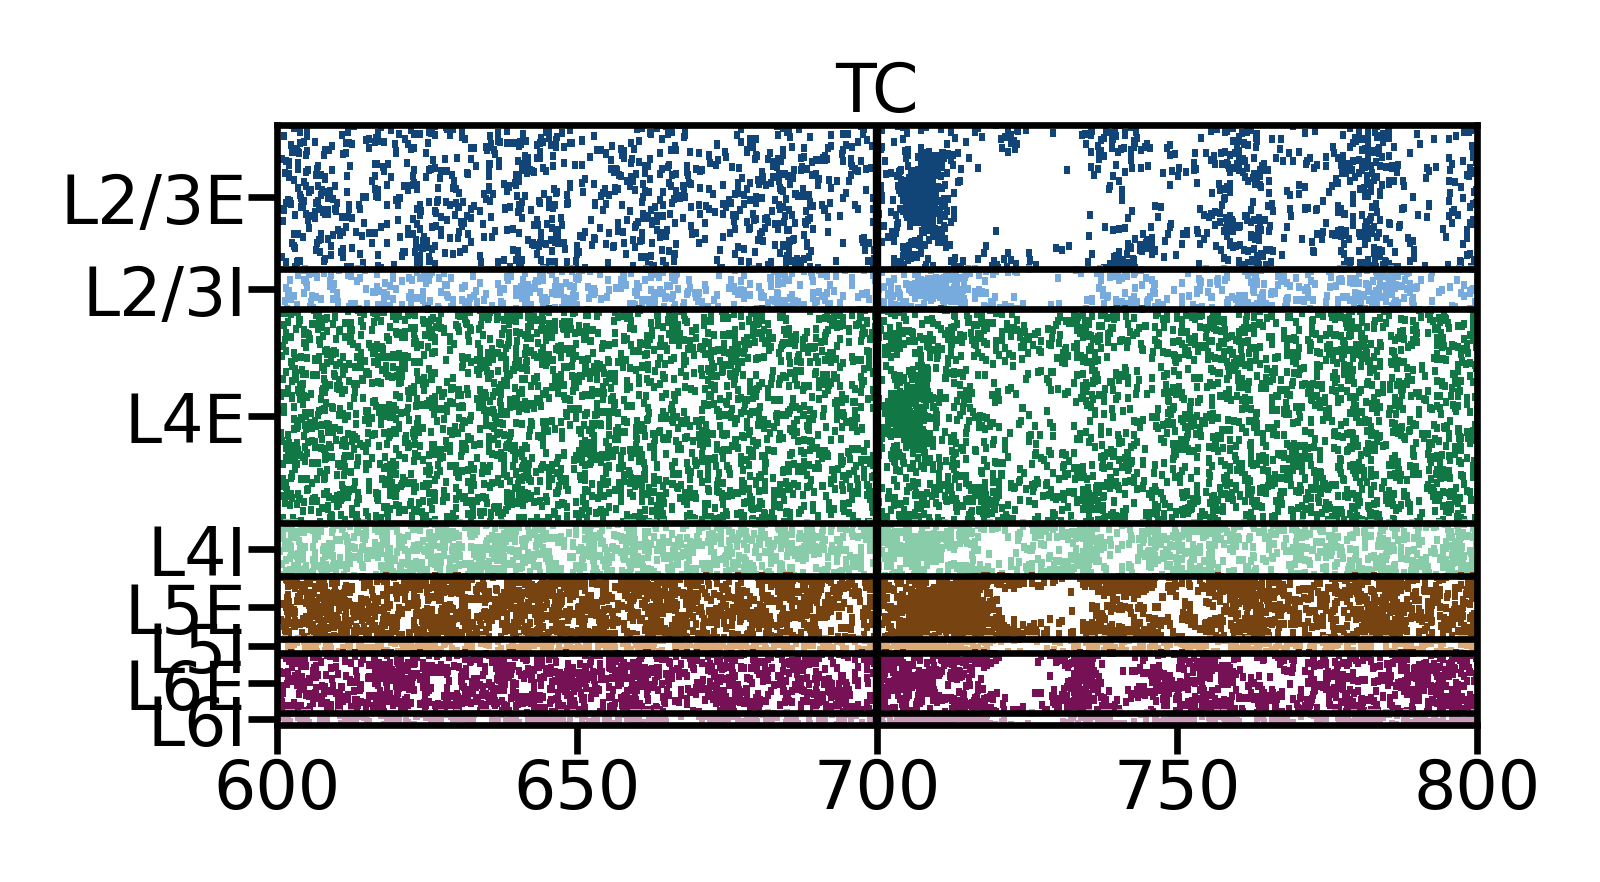

In [7]:
def plot_raster(gs,
                populations,
                all_sptrains,
                all_pos_sorting_arrays,
                time_step,
                time_interval,
                sample_step,
                xticklabels=True,
                xlabel=True,
                yticks=True,
                yticklabels=True,
                markersize_scale=0.25,
               pop_colors=pop_colors, pop_labels=pop_labels):
        """
        Plots spike raster to gridspec cell.

        Neurons are sorted according to sorting_axis applied in
        all_pos_sorting_arrays.

        Parameters
        ----------
        gs
            A gridspec cell to plot into.
        populations
            List of population names.
        all_sptrains
            Open h5 file with all spike trains.
        all_pos_sorting_arrays
            Open h5 file with position sorting arrays.
        time_step
            Time step corresponding to spike trains.
        time_interval
            Time interval to plot.
        sample_step
            Every sample_step'th neuron is shown (default being 1 means that all
            neurons are shown).
        xticklabels
            Boolean indicating if x-ticklabels shall be plotted.
        xlabel
            Boolean indicating if x-label shall be plotted.
        yticklabels
            Boolean indicating if y-ticklabels shall be plotted.
        markersize_scale
            Scaling factor for marker size.

        Returns
        -------
        ax
            Axis to put a label to.
        """
        nums_shown = []
        yticks = []
        ax = plt.subplot(gs)
        for i, X in enumerate(populations):
            data = load_h5_to_sparse_X(X, all_sptrains)

            # slice according to time interval
            time_indices = np.arange(
                time_interval[0] / time_step,
                time_interval[1] / time_step).astype(int)
            data = data[:, time_indices]

            # sort according to spatial axis
            space_indices = all_pos_sorting_arrays[X][()]
            data = data[space_indices, :]

            # subsample if specified
            if sample_step > 1:
                sample_indices = np.zeros(data.shape[0], dtype=bool)
                sample_indices[::sample_step] = True
                data = data[sample_indices, :]

            # final number of neurons to be shown
            num_neurons = data.shape[0]

            # get x,y indices and plot
            y, x = np.nonzero(data.toarray())
            ax.plot(x * time_step + time_interval[0],
                    -(np.sum(nums_shown) + y),
                    marker='$.$',
                    markersize=matplotlib.rcParams['lines.markersize'] *
                    markersize_scale,
                    color=pop_colors[i],
                    markeredgecolor='none',
                    linestyle='',
                    rasterized=True)
            nums_shown.append(num_neurons)
            yticks.append(-np.sum(nums_shown) + 0.5 * nums_shown[-1])

        # draw lines to separate populations on top
        for i, X in enumerate(populations[:-1]):
            ax.plot(time_interval, [-np.sum(nums_shown[:i + 1])] * 2,
                    'k',
                    linewidth=matplotlib.rcParams['axes.linewidth'])

        ax.set_xlim(time_interval[0], time_interval[1])
        ax.set_ylim(-np.sum(nums_shown), 0)

        ax.set_yticks(yticks)

        if xlabel:
            ax.set_xlabel('time (ms)')
        if not xticklabels:
            ax.set_xticklabels([])
        if yticklabels:
            ax.set_yticklabels(pop_labels[:len(nums_shown)])
        else:
            ax.set_yticklabels([])
        return ax
    
fig_width = 1#8.5/2.54 # TODO
fig = plt.figure(figsize=(fig_width, fig_width))
gs = gridspec.GridSpec(1,1)
gs.update(left=0, right=2, bottom=0, top=1)


sim_resolution = 0.1 # ms
raster_time_interval_short = np.array([600., 800.])
th_start = 700.
populations = np.array(
        ['L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I'])
plot_raster(
        gs[0],
        populations=populations,
        all_sptrains=d['all_sptrains'],
        all_pos_sorting_arrays=d['all_pos_sorting_arrays'],
        time_step=sim_resolution,
        time_interval=raster_time_interval_short,
        sample_step=100,
        xlabel=False)
plt.gca().tick_params(axis='both', which='major', pad=0.2)
plt.axvline(x=th_start, color='k')
plt.title('TC', pad=0.2, fontsize=fs)

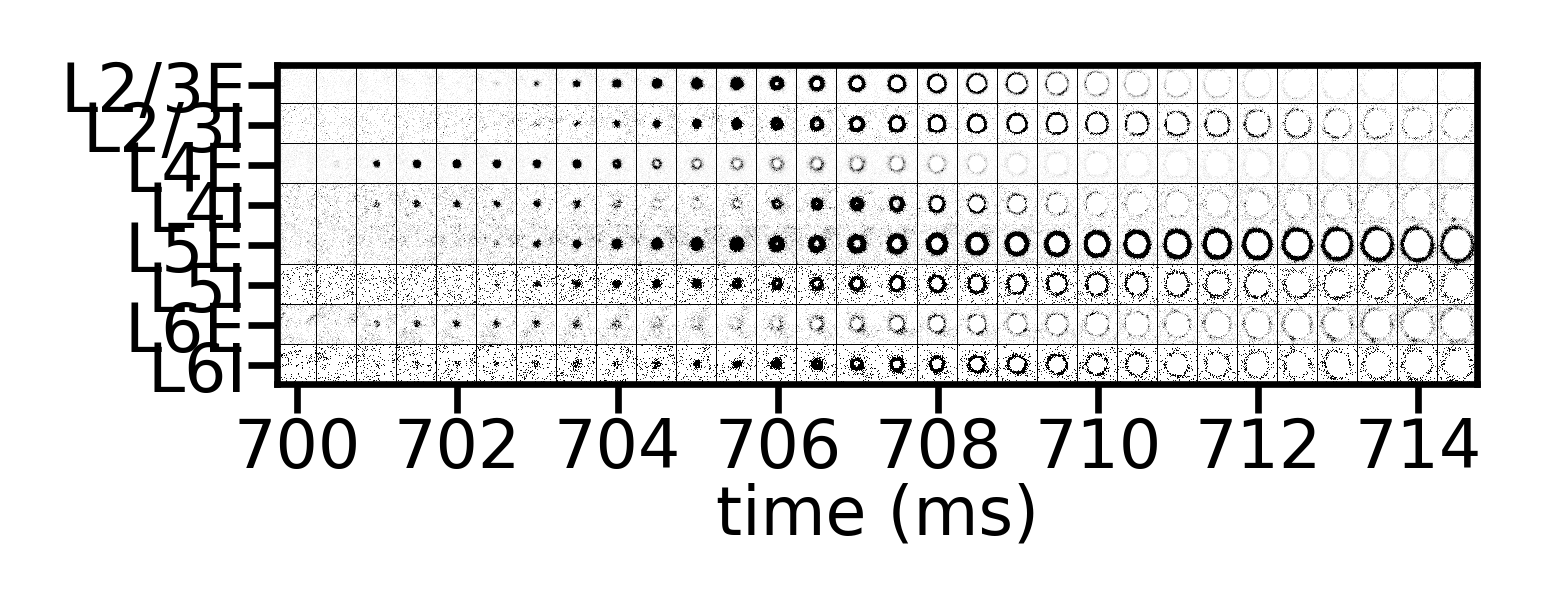

In [8]:
def plot_spatial_snapshots(gs,
                               populations,
                               all_inst_rates_bintime_binspace,
                               binsize_time,
                               space_bins,
                               start_time=700.,  # ms
                               step=1,  # multiplication
                               nframes=30,
                               tickstep=2,
                               snapshots_max_rate=50.,
                               pop_labels=pop_labels
                               ):
        """
        """
        start_frame = int(start_time / binsize_time)
        end_frame = start_frame + (nframes - 1) * step
        times = np.arange(start_frame, end_frame + 1, step) * binsize_time

        numbins = space_bins.size - 1

        # minimum rate a bit below 0 to avoid issues with cmap.set_under()
        vmin = -0.001
        # separator between sub-panels masked with cmap.set_under()
        val_sep = -1

        for X in populations:
            data = load_h5_to_sparse_X(X, all_inst_rates_bintime_binspace)
            data = data[:, start_frame:end_frame + 1:step].toarray()
            data = data.reshape((numbins, -1, data.shape[-1]))

            # append frames as columns
            separator_frames = np.array([val_sep] * (numbins)).reshape(-1, 1)
            data0 = np.concatenate((data[:, :, 0], separator_frames), axis=1)
            for n in np.arange(nframes - 1):
                data_apnd = np.concatenate((data0, data[:, :, n + 1]), axis=1)
                data0 = np.concatenate((data_apnd, separator_frames), axis=1)

            # append populations as rows
            separator_pops = \
                np.array([val_sep] * np.shape(data_apnd)[1]).reshape(1, -1)
            if X == populations[0]:
                plot_data0 = np.concatenate(
                    (data_apnd, separator_pops), axis=0)
            else:
                plot_data = np.concatenate((plot_data0, data_apnd), axis=0)
                plot_data0 = np.concatenate(
                    (plot_data, separator_pops), axis=0)

        # ticks dependent on number of spatial bins
        # (set up for default horizontal orientation)
        xy_ticks = [numbins / 2.]
        for t in np.arange(np.max([nframes - 1, len(populations) - 1])):
            xy_ticks.append(xy_ticks[-1] + numbins + 1.)

        xticks = xy_ticks[:nframes:tickstep]
        ticklabels = times[::tickstep]
        if (int(ticklabels[0]) == ticklabels[0] and
                int(ticklabels[1]) == ticklabels[1]):
            ticklabels = ticklabels.astype(int)

        ax = plt.subplot(gs)

        cmap = matplotlib.cm.get_cmap('Greys').copy()
        cmap.set_under(color='black')

        im = ax.imshow(plot_data, interpolation='nearest', cmap=cmap,
                       vmin=vmin,
                       vmax=snapshots_max_rate)
        ax.set_xticks(xticks)
        ax.set_xticklabels(ticklabels)
        ax.set_xlabel('time (ms)')
        ax.set_yticks(xy_ticks[:len(populations)])
        ax.set_yticklabels(pop_labels[:len(populations)])
        return ax

fig_width = 1#8.5/2.54 # TODO
fig = plt.figure(figsize=(fig_width, fig_width))
gs = gridspec.GridSpec(1,1)
gs.update(left=0, right=2, bottom=0, top=1)

binsize_time = 0.5
binsize_space = 0.1
extent = 4.
space_bins = np.linspace(-extent / 2., extent / 2., int(extent / binsize_space + 1))
snapshots_max_rate = 50.

plot_spatial_snapshots(
        gs[0],
        populations=populations,
        all_inst_rates_bintime_binspace=d['all_inst_rates_bintime_binspace'],
        binsize_time=binsize_time,
        space_bins=space_bins,
        start_time=th_start,
        tickstep=4,
        snapshots_max_rate=snapshots_max_rate,
pop_labels=pop_labels)
plt.gca().tick_params(axis='both', which='major', pad=0.2)

Set up figure.

In [ ]:
def create_figure():
    fig_width_1col = 8.5/2.54
    fig = plt.figure(figsize=(fig_width_1col,fig_width_1col))
    gs = gridspec.GridSpec(5, 10)
    gs.update(left=0.12, right=0.96, bottom=0.08,
              top=1.02, hspace=0)

    # network sketch
    plot_mesocircuit_icon(gs[0, -3:-1])

    gs_bottom = gridspec.GridSpecFromSubplotSpec(
        5, 1, subplot_spec=gs[1:, :], hspace=0.35)

    # raster
    plot_raster(
        gs_bottom[:3, 0],
        populations=populations,
        all_sptrains=d['all_sptrains'],
        all_pos_sorting_arrays=d['all_pos_sorting_arrays'],
        time_step=sim_resolution,
        time_interval=raster_time_interval_short,
        sample_step=100,
        xlabel=False)

    plt.gca().tick_params(axis='both', which='major', pad=0.2)
    plt.axvline(x=th_start, color='k')
    plt.title('TC', pad=0.2, fontsize=fs)


    # spatial snapshots
    plot_spatial_snapshots(
        gs_bottom[3:, 0],
        populations=populations,
        all_inst_rates_bintime_binspace=d['all_inst_rates_bintime_binspace'],
        binsize_time=binsize_time,
        space_bins=space_bins,
        start_time=th_start,
        tickstep=4,
        snapshots_max_rate=snapshots_max_rate,
        pop_labels=pop_labels)
    plt.gca().tick_params(axis='both', which='major', pad=0.2)
    return

create_figure()